In [ ]:
pip install mlflow
pip install xgboost
pip install scikit-learn

In [11]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_tree, XGBClassifier, to_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import log_loss, accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, precision_score, recall_score, f1_score
#import seaborn as sns
#import ipywidgets as widgets
#from IPython.display import display
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import clone
import mlflow
import mlflow.xgboost
from ml_models.xgboost_model import XGBoostTunedModelRunner, XGBoostBaseModelRunner
from utils.metrics import collect_all_metrics
from utils.plots import plot_runner_method



In [14]:
file_path_spine_features_train = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw_images', 'archive', 'features', 'train', 'features.csv'))
file_path_spine_features_val = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw_images', 'archive', 'features', 'val', 'features.csv'))
file_path_spine_targets_train = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw_images', 'archive', 'labels', 'train', 'labels.csv'))
file_path_spine_targets_val = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw_images', 'archive', 'labels', 'val', 'labels.csv'))

In [15]:
#model = xgb.XGBClassifier()

df_features_train = pd.read_csv(file_path_spine_features_train)
df_features_val = pd.read_csv(file_path_spine_features_val)
df_targets_train = pd.read_csv(file_path_spine_targets_train)
df_targets_val = pd.read_csv(file_path_spine_targets_val)

In [16]:
df_features_train['image_filename'] = df_features_train['image_filename'] + '_train'
df_features_val['image_filename'] = df_features_val['image_filename'] + '_val'
df_targets_train['image_filename'] = df_targets_train['image_filename'] + '_train'
df_targets_val['image_filename'] = df_targets_val['image_filename'] + '_val'


In [17]:
df_features = pd.concat([df_features_train, df_features_val], ignore_index=True)
df_targets = pd.concat([df_targets_train, df_targets_val], ignore_index=True)


In [18]:
df = pd.merge(df_features, df_targets, on='image_filename')

In [19]:
target_columns = ['Head', 'Neck', 'Shoulder', 'Thoraric_Spine', 'Lumbar_Spine']
X = df.drop(target_columns + ['image_filename'], axis=1)
y = df[target_columns]

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:

runners = {}

for target in target_columns:
    runner = XGBoostBaseModelRunner(target, X_train, y_train, X_val, y_val)
    runner.train()
    runner.evaluate()
    runner.log_to_mlflow(experiment_name="XGBoost_Basemodel")
    runners[target] = runner

/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:41:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/10 12:41:46 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_Basemodel' does not exist. Creating a new experiment.
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:41:46] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:41:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/michael/Documents/Posture_Detection/posedetec

In [24]:
collect_all_metrics(runners)

,Head,Neck,Shoulder,Thoraric_Spine,Lumbar_Spine
Accuracy,0.625,0.604167,0.604167,0.5,0.479167
Precision,0.428571,0.575924,0.555556,0.484848,0.512191
Recall,0.176471,0.604167,0.25,0.695652,0.479167
F1 Score,0.25,0.577691,0.344828,0.571429,0.476374
ROC AUC,0.664137,0.764828,0.617857,0.573913,0.591706
Logloss,0.815209,1.110237,0.76877,0.864405,1.207439


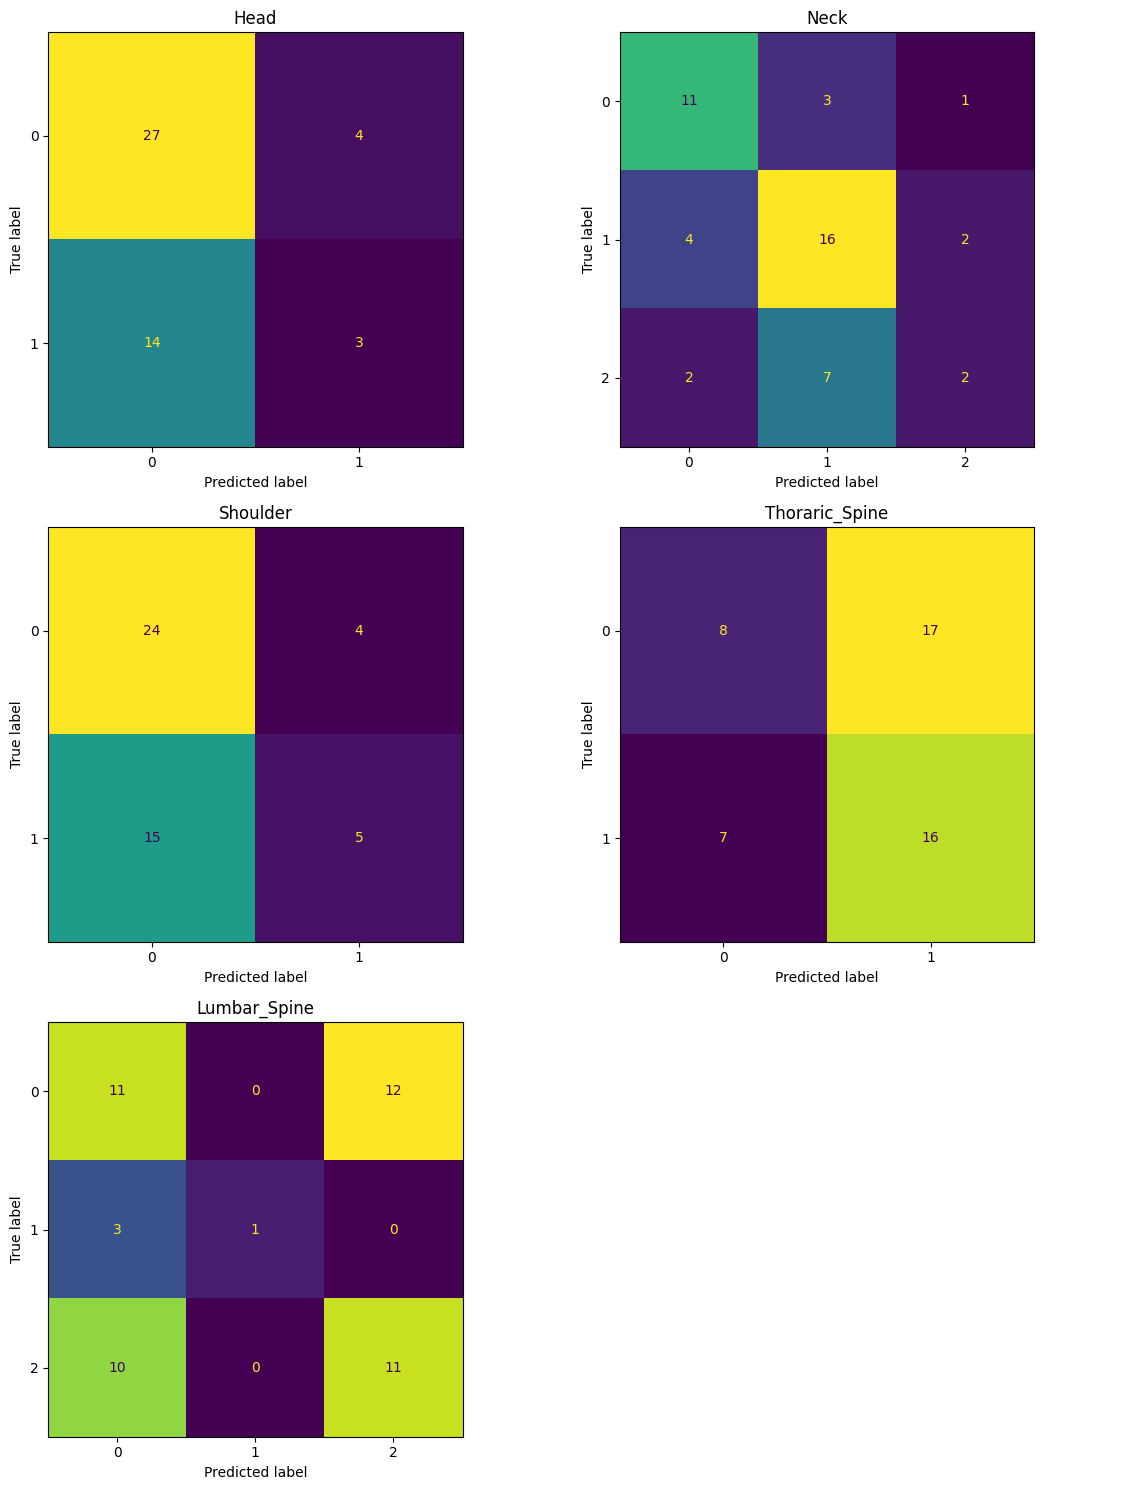

In [25]:
plot_runner_method(runners, method_name="plot_confusion_matrix")

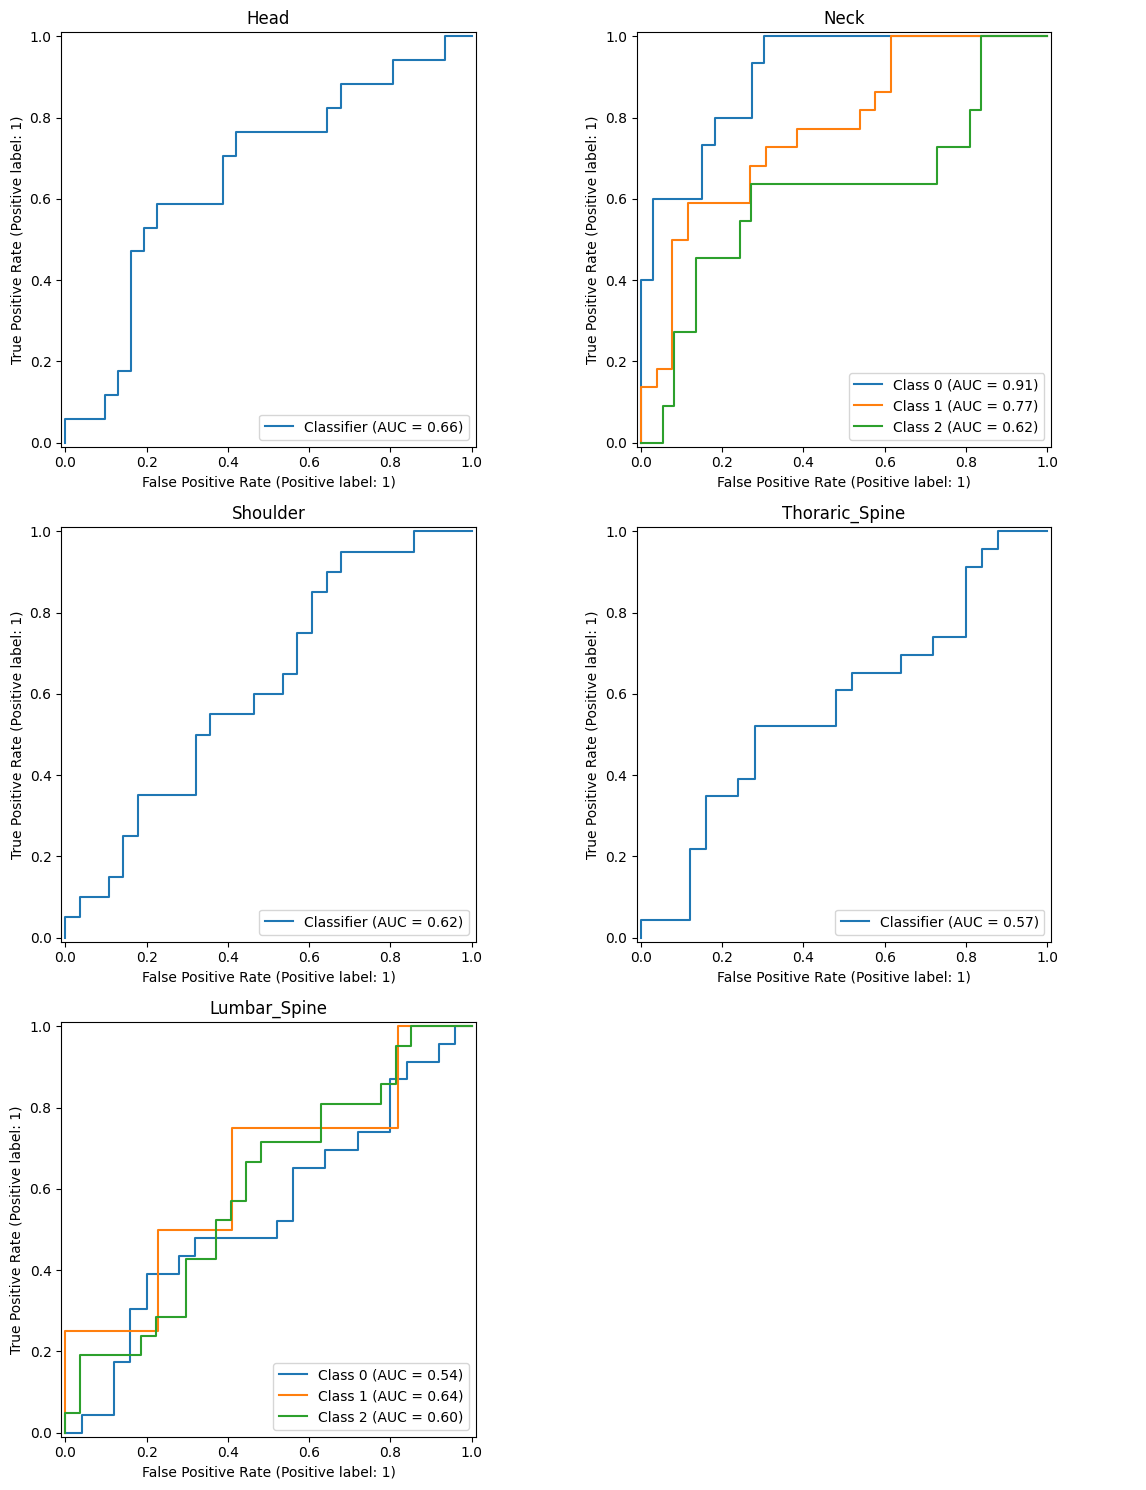

In [26]:
plot_runner_method(runners, method_name="plot_roc_curve")

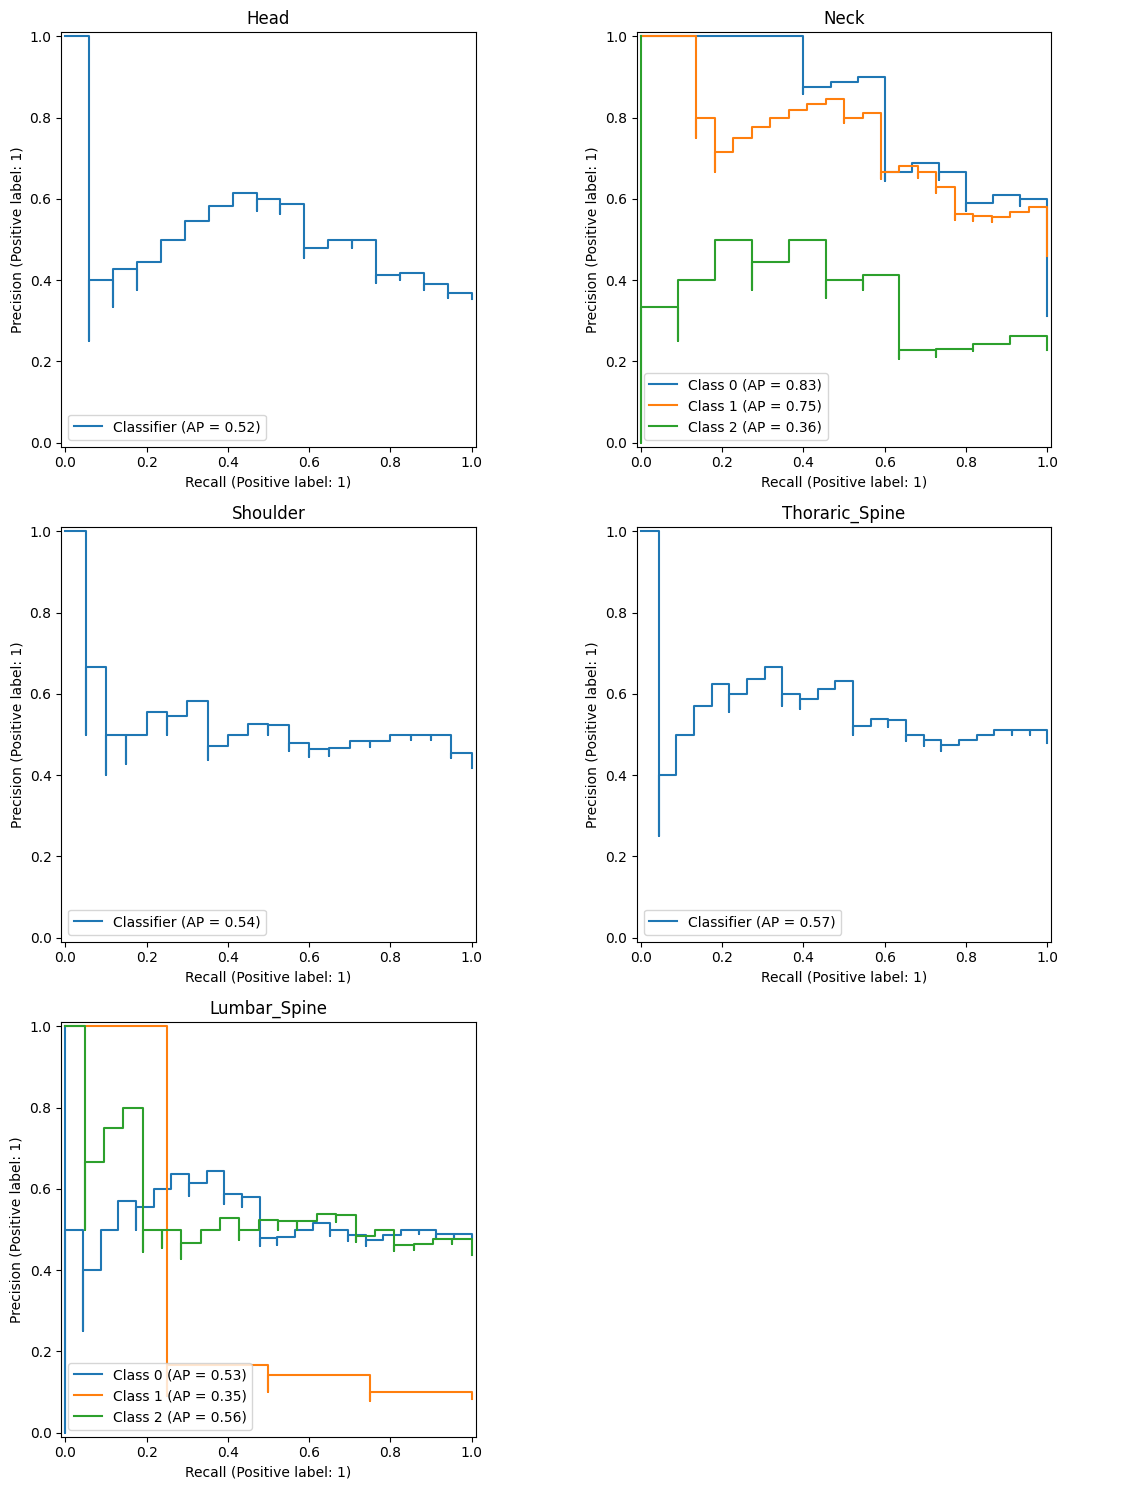

In [27]:
plot_runner_method(runners, method_name="plot_precision_recall")

In [28]:

param_grids = {
    'Head': {
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3],
    'gamma': [0, 0.1]
},
    'Neck': {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7],
    'gamma': [0.2, 0.3],
    'reg_alpha': [0.2, 0.5],
    'reg_lambda': [1, 1.5, 2]
},
    'Shoulder': {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, 2],
    'gamma': [0, 0.1]
},
    'Thoraric_Spine': {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7],
    'gamma': [0.2, 0.3],
    'reg_alpha': [0.3, 0.5],
    'reg_lambda': [1, 2]
},
    'Lumbar_Spine': {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, 2],
    'reg_lambda': [1, 2],
    'reg_alpha': [0, 0.1]
}
}


In [29]:
scorings = {
    'Head': 'roc_auc',
    'Neck': 'f1_macro',
    'Shoulder': 'recall',
    'Thoraric_Spine': 'precision',
    'Lumbar_Spine': 'f1_macro'
}

In [30]:

runners_tuned = {}

for target in target_columns:
    runner_tuned = XGBoostTunedModelRunner(
        target,
        X_train, y_train,
        X_val, y_val,
        param_grid=param_grids[target],
        scoring=scorings[target]
    )
    runner_tuned.tune(n_iter=20)
    runner_tuned.evaluate()
    runner_tuned.log_to_mlflow("XGBoost_RandomizedSearchCV")
    runners_tuned[target] = runner_tuned

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Best params for Head: {'subsample': 0.8, 'scale_pos_weight': 2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:51:34] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:51:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameter

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Best params for Neck: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:53:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:53:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameter

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Best params for Shoulder: {'subsample': 0.8, 'scale_pos_weight': 2, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:54:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:54:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameter

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Best params for Thoraric_Spine: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.3, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:55:35] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:55:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:38] WARNING: /workspace/src/learne

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:55:

Best params for Lumbar_Spine: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 2, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


/home/michael/Documents/Posture_Detection/posedetection/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:59:10] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/10 12:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [31]:
collect_all_metrics(runners_tuned)

,Head,Neck,Shoulder,Thoraric_Spine,Lumbar_Spine
Accuracy,0.666667,0.604167,0.604167,0.479167,0.5
Precision,0.545455,0.550409,0.538462,0.470588,0.532793
Recall,0.352941,0.604167,0.35,0.695652,0.5
F1 Score,0.428571,0.563996,0.424242,0.561404,0.495915
ROC AUC,0.679317,0.786307,0.578571,0.554783,0.596539
Logloss,0.84002,0.961316,0.944663,0.838495,1.369138


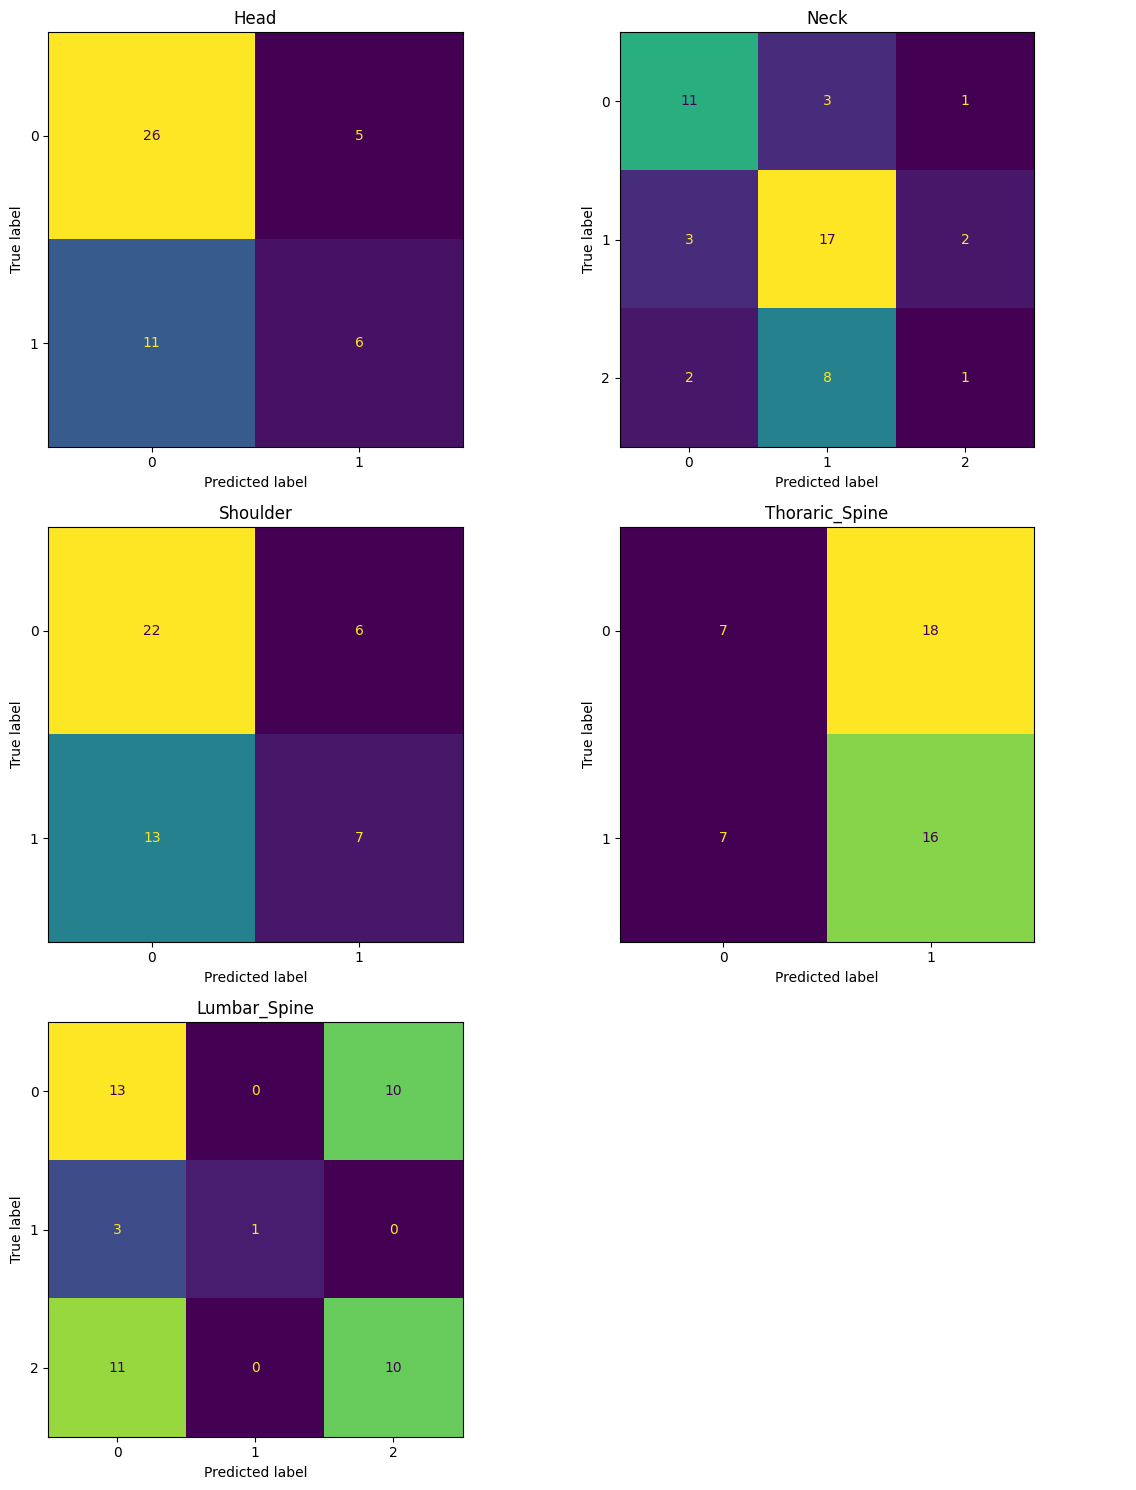

In [32]:
plot_runner_method(runners_tuned, method_name="plot_confusion_matrix")

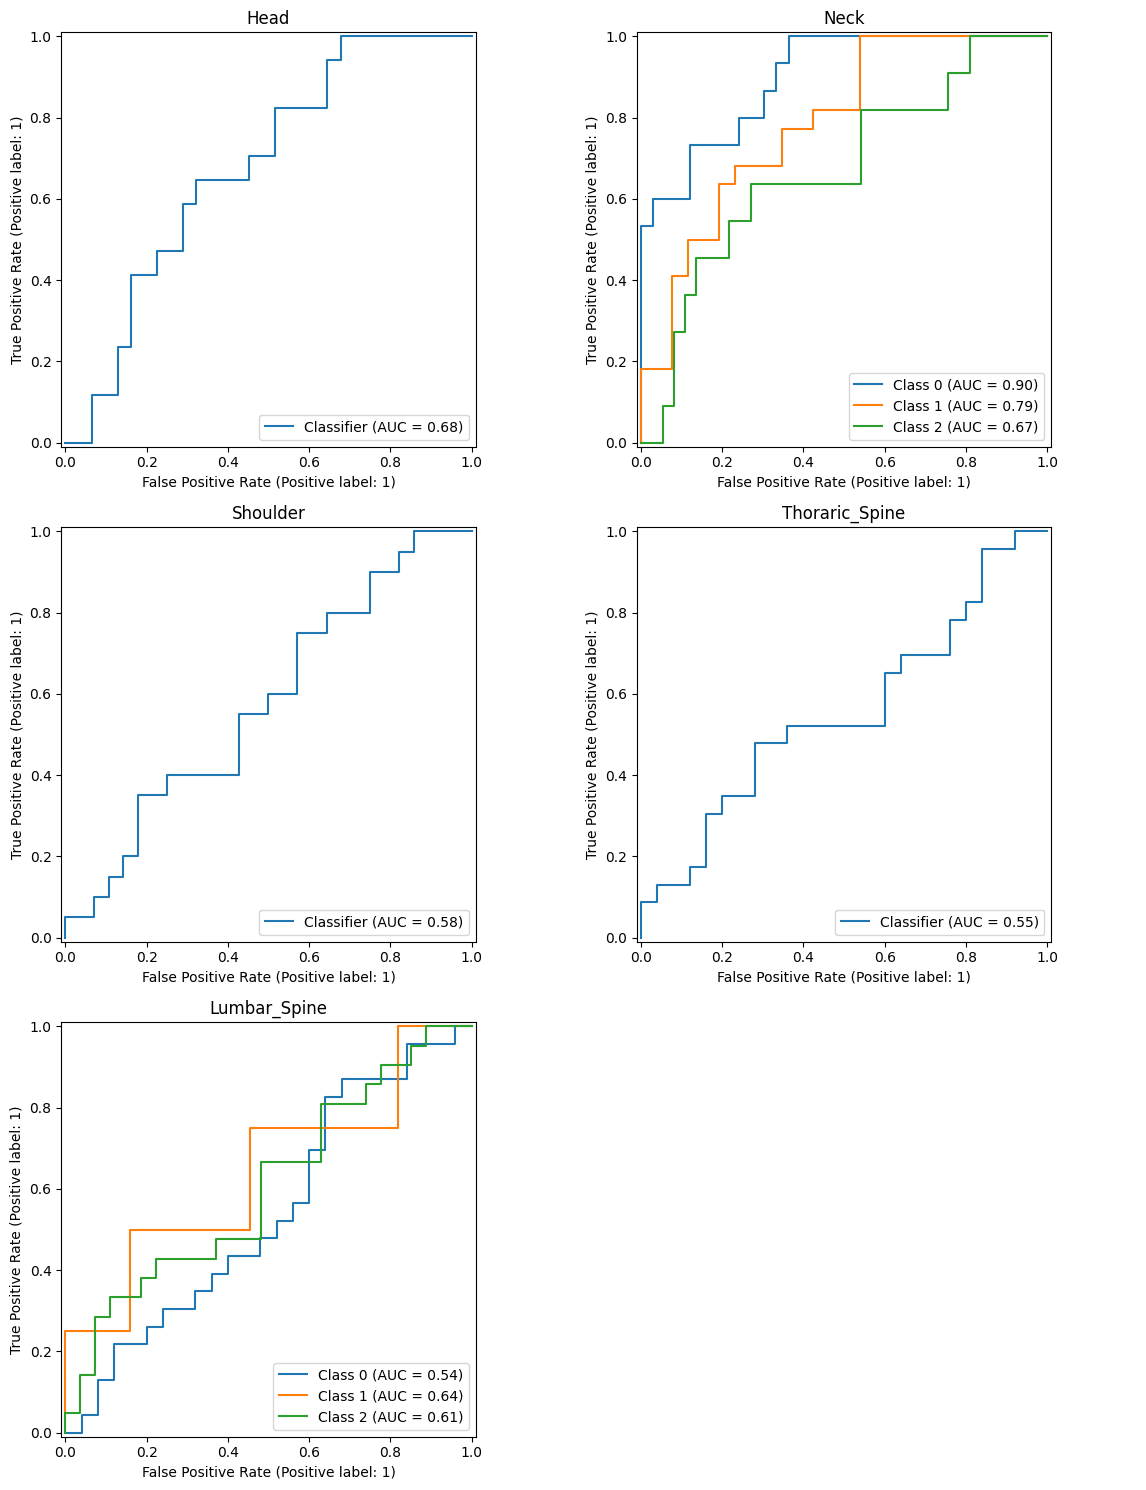

In [33]:
plot_runner_method(runners_tuned, method_name="plot_roc_curve")

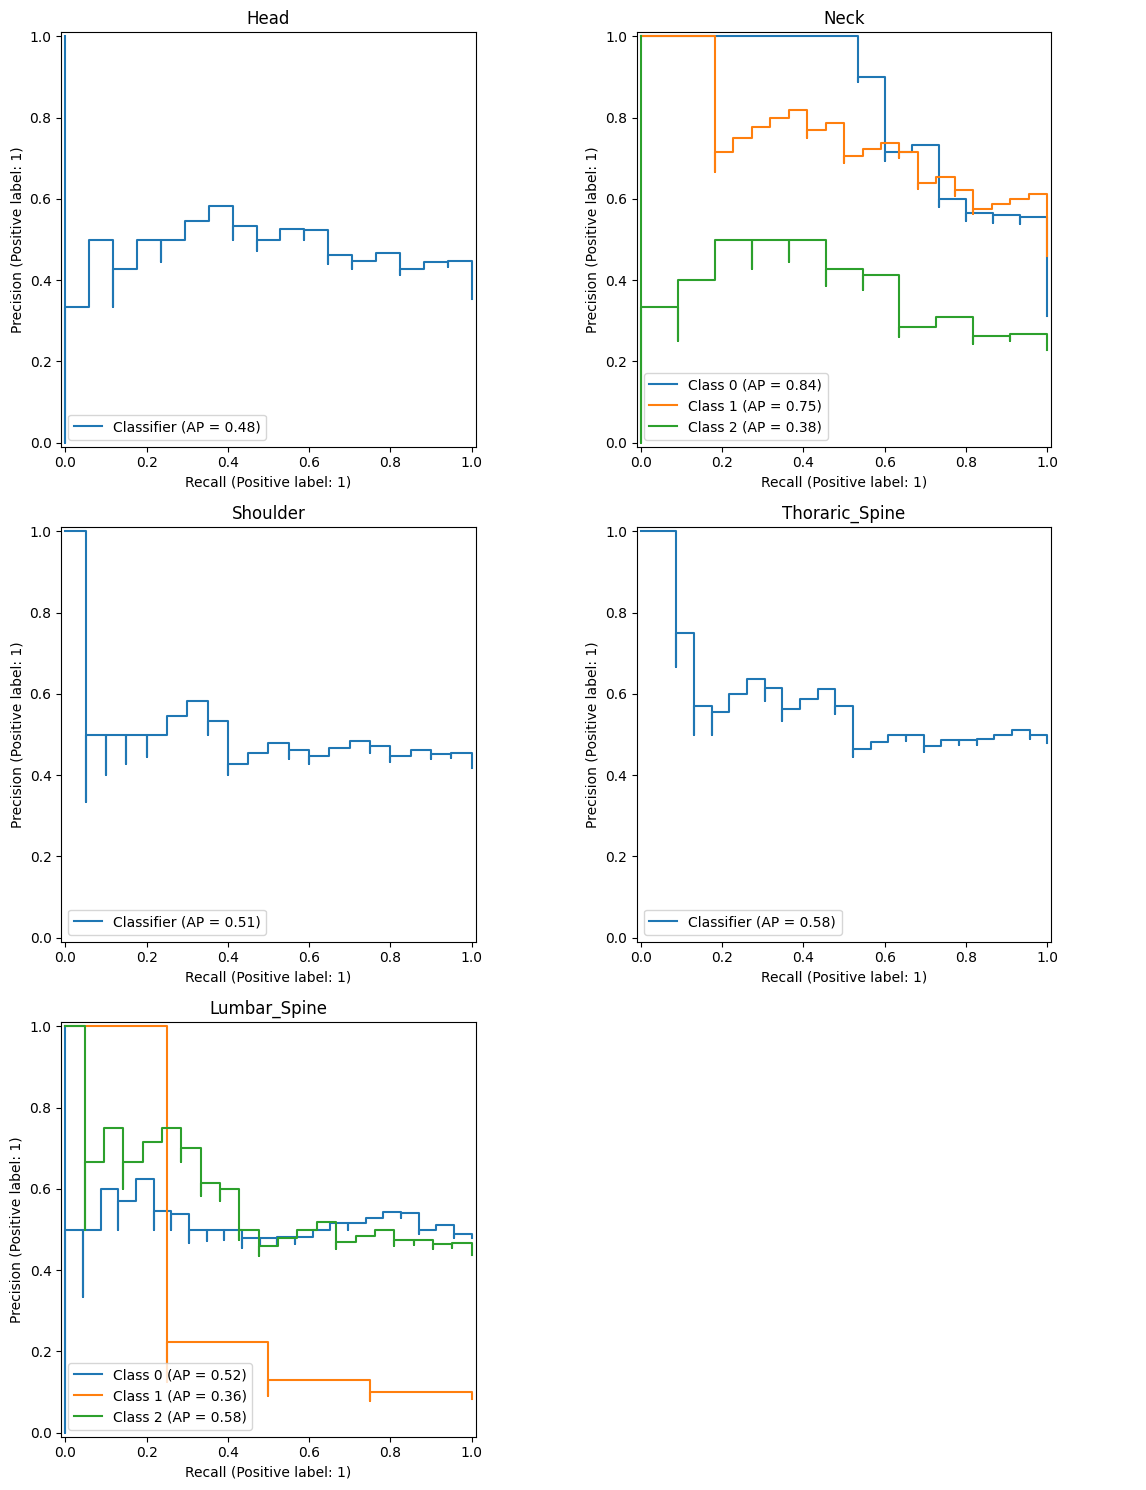

In [34]:
plot_runner_method(runners_tuned, method_name="plot_precision_recall")

In [ ]:
df_metrics = collect_all_metrics(runners)

In [ ]:
df_metrics